# totoの平均当選金額、当選確率から期待値を計算する


## WEBスクレイピングによる当選金額データの取得
* toto公式サイト（ http://sport-kuji.toto-dream.com/dci/I/IPB/IPB01.do?op=initLotResultLsttoto ）からWEBスクレイピングで当選金額データを取得する
* 過去の結果を閲覧できるURLは http://sport-kuji.toto-dream.com/dci/I/IPB/IPB01.do?op=lnkHoldCntLotResultLsttoto&holdCntId={開催回}
* {開催回}の部分の数字を変えれば、各回のURLにアクセスすることができる

### pandasを使用して対象URLからテーブル要素を取得
toto、mini toto-A組、mini toto-B組、totoGOAL3のデータだけを抽出するために、pandasで取得したデータに規則性があるかを調査する

In [1]:
import pandas
from IPython.core.display import display

target_url_sample = 'http://sport-kuji.toto-dream.com/dci/I/IPB/IPB01.do?op=lnkHoldCntLotResultLsttoto&holdCntId=0261'
fetched_dataframes_sample = pandas.io.html.read_html(target_url_sample)

毎回toto、mini toto-A組、mini toto-B組、totoGOAL3の4種類の宝くじが開催されるとは限らない。
ダイレクトに要素番号を指定すると期待通りのデータが取得できない。

よって下記の処理を行う。

1. 全てのdataframe要素について、行番号1、列番号0の文字列が"当せん金"かどうかを判定する
1. 行番号1、列番号0が"当せん金"の要素は当選結果のdataframeとみなす
1. 行番号1、列番号0が"当せん金"の要素番号から-2した要素番号の行番号0、列番号0を取得する
1. 取得した文字列に、特定の文字列が含まれているか判定する
    - 取得した文字列に"回 toto　くじ結果"が含まれて入れば処理1で取得した当選結果はtotoとみなす
    - 取得した文字列に"mini toto-A組"が含まれて入れば処理1で取得した当選結果はmini toto-A組とみなす
    - 取得した文字列に"mini toto-B組"が含まれて入れば処理1で取得した当選結果はmini toto-B組とみなす
    - 取得した文字列に"totoGOAL3"が含まれて入れば処理1で取得した当選結果はtotoGOAL3とみなす

In [2]:
def separateLotteryType(df):
    
    DfToto = pandas.DataFrame()
    DfTotoMiniA = pandas.DataFrame()
    DfTotoMiniB = pandas.DataFrame()
    DfTotoGoal3 = pandas.DataFrame()
    
    for index, item in enumerate(df):
        if len(item.isnull()) < 2:
            continue

        if item.iat[1, 0] == '当せん金':
            if df[index - 2].iat[0,0].find('回 toto　くじ結果') != -1:
                DfToto = item
            elif df[index - 2].iat[0,0].find('mini toto-A組') != -1:
                DfTotoMiniA = item
            elif df[index - 2].iat[0,0].find('mini toto-B組') != -1:
                DfTotoMiniB = item
            elif df[index - 2].iat[0,0].find('totoGOAL3') != -1:
                DfTotoGoal3 = item
    
    return DfToto, DfTotoMiniA, DfTotoMiniB, DfTotoGoal3

2007年の第261回から2018年の第1046回までのデータを取得し、separateLotteryType()をつかってtoto、mini toto-A組、mini toto-B組、totoGOAL3の当選結果に分類する。
第260回以前（2006年以前）はtotoに3等がない為、使用するデータから除外した。

In [3]:
from tqdm import tqdm

# toto、mini toto-A組、mini toto-B組、totoGOAL3の当選結果を格納する配列
DfArrToto = []
DfArrTotoMiniA = []
DfArrTotoMiniB = []
DfArrTotoGoal3 = []

for lotteryNo in tqdm(range(261,1046)):
    if lotteryNo < 1000:
        number = '0' + str(lotteryNo)
    else:
        number = str(lotteryNo)
    
    target_url = 'http://sport-kuji.toto-dream.com/dci/I/IPB/IPB01.do?op=lnkHoldCntLotResultLsttoto&holdCntId='+ str(number) 

    fetched_dataframes = pandas.io.html.read_html(target_url)
    DfToto, DfTotoMiniA, DfTotoMiniB, DfTotoGoal3 = separateLotteryType(fetched_dataframes)
    
    if DfToto.empty == False:
        DfArrToto.append(DfToto)
        
    if DfTotoMiniA.empty == False:
        DfArrTotoMiniA.append(DfTotoMiniA)
        
    if DfTotoMiniB.empty == False:
        DfArrTotoMiniB.append(DfTotoMiniB)

    if DfTotoGoal3.empty == False:
        DfArrTotoGoal3.append(DfTotoGoal3)
    
#   print(target_url)


100%|██████████| 785/785 [04:46<00:00,  3.11it/s]


[ 23.  18.  11.  10.   6.  12.  13.   7.   5.   7.   0.   5.   2.   4.   3.
   4.   5.   7.   4.   3.   2.   3.   1.   0.   3.   4.   1.   2.   4.   2.
   4.   1.   4.   4.   5.   4.   3.   2.   3.   3.   2.   3.   1.   2.   1.
   2.   1.   1.   0.   0.   4.   2.   1.   2.   2.   1.   2.   0.   0.   1.
   1.   0.   2.   1.   1.   1.   3.   2.   2.   2.   1.   0.   2.   4.   3.
   2.   0.   1.   0.   1.   1.   0.   3.   0.   0.   0.   0.   0.   0.   5.
   1.   0.   0.   3.   0.   0.   0.   0.   0.   0.   2.]


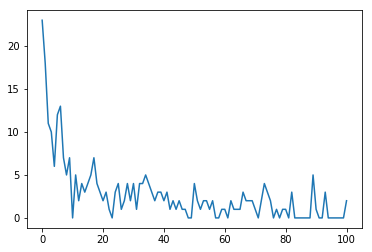

In [4]:
# 賞金の金額を簡易的にヒストグラムで表示
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

temp = []
temp2 = np.zeros(101)
for d in DfArrToto:
    data = int(d.iat[1,1].replace("円", "").replace(",", ""))

    if(data == 0 or data > 100000000):
        continue
    
        temp.append(data)
    index = int(data / 1000000)
#     print(index)
    temp2[index] += 1
    
# sortedTemp = sorted(temp)
plt.plot(temp2)
# plt.pie(temp2)
# tempDF = pandas.DataFrame(temp)
print(temp2)



## 賞金総合計、開催回数、平均償金額を計算
### totoの賞金総合計、開催回数、平均償金額を計算

In [5]:
totoTotalFirstPrize = 0
totoTotalSecondPrize = 0
totoTotalThirdPrize = 0
totoHeldNumber = len(DfArrToto)

for item in DfArrToto:

    firstPrize = int(item.iat[1,1].replace("円", "").replace(",", ""))
    secondPrize = int(item.iat[1,2].replace("円", "").replace(",", ""))
    thirdPrize = int(item.iat[1,3].replace("円", "").replace(",", ""))
    
    totoTotalFirstPrize += firstPrize
    totoTotalSecondPrize += secondPrize
    totoTotalThirdPrize += thirdPrize

totoAverageFirstPrize = totoTotalFirstPrize / totoHeldNumber
totoAverageSecondPrize = totoTotalSecondPrize / totoHeldNumber
totoAverageThirdPrize = totoTotalThirdPrize / totoHeldNumber

print('1等賞金総合計：' + str(totoTotalFirstPrize) + '円')
print('2等賞金総合計：' + str(totoTotalSecondPrize) + '円')
print('3等賞金総合計：' + str(totoTotalThirdPrize) + '円')
print('開催回数：' + str(totoHeldNumber) + '回')
print('1等平均賞金：' + str(totoAverageFirstPrize) + '円')
print('２等平均賞金：' + str(totoAverageSecondPrize) + '円')
print('3等平均賞金：' + str(totoAverageThirdPrize) + '円')


1等賞金総合計：13358300031円
2等賞金総合計：434911036円
3等賞金総合計：26243080円
開催回数：473回
1等平均賞金：28241649.114164904円
２等平均賞金：919473.6490486258円
3等平均賞金：55482.198731501056円


### mini toto-A組の賞金総合計、開催回数、平均償金額を計算

In [6]:
totoMiniATotalPrize = 0
totoMiniAHeldNumber = len(DfArrTotoMiniA)

for item in DfArrTotoMiniA:

    firstPrize = int(item.iat[1,1].replace("円", "").replace(",", ""))
    
    totoMiniATotalPrize += firstPrize

totoMiniAAveragePrize = totoMiniATotalPrize / totoMiniAHeldNumber

print('1等賞金総合計：' + str(totoMiniATotalPrize) + '円')
print('開催回数：' + str(totoMiniAHeldNumber) + '回')
print('1等平均賞金：' + str(totoMiniAAveragePrize) + '円')

1等賞金総合計：9616484円
開催回数：669回
1等平均賞金：14374.415545590433円


### mini toto-B組の賞金総合計、開催回数、平均償金額を計算

In [7]:
totoMiniBTotalPrize = 0
totoMiniBHeldNumber = len(DfArrTotoMiniB)

for item in DfArrTotoMiniB:

    firstPrize = int(item.iat[1,1].replace("円", "").replace(",", ""))
    
    totoMiniBTotalPrize += firstPrize
    
totoMiniBAveragePrize = totoMiniBTotalPrize / totoMiniBHeldNumber

print('1等賞金総合計：' + str(totoMiniBTotalPrize) + '円')
print('開催回数：' + str(totoMiniBHeldNumber) + '回')
print('1等平均賞金：' + str(totoMiniBAveragePrize) + '円')

1等賞金総合計：8648516円
開催回数：564回
1等平均賞金：15334.248226950354円


### totoGOAL3の賞金総合計、開催回数、平均償金額を計算

In [8]:
totoGoal3TotalFirstPrize = 0
totoGoal3TotalSecondPrize = 0
totoGoal3HeldNumber = len(DfArrTotoGoal3)

for item in DfArrTotoGoal3:

    firstPrize = int(item.iat[1,1].replace("円", "").replace(",", ""))
    secondPrize = int(item.iat[1,2].replace("円", "").replace(",", ""))
    
    totoGoal3TotalFirstPrize += firstPrize
    totoGoal3TotalSecondPrize += secondPrize

totoGoal3AverageFirstPrize = totoGoal3TotalFirstPrize / totoGoal3HeldNumber
totoGoal3AverageSecondPrize = totoGoal3TotalSecondPrize / totoGoal3HeldNumber

print('1等賞金総合計：' + str(totoGoal3TotalFirstPrize) + '円')
print('2等賞金総合計：' + str(totoGoal3TotalSecondPrize) + '円')
print('開催回数：' + str(totoGoal3HeldNumber) + '回')
print('1等平均賞金：' + str(totoGoal3AverageFirstPrize) + '円')
print('２等平均賞金：' + str(totoGoal3AverageSecondPrize) + '円')

1等賞金総合計：119398282円
2等賞金総合計：3081560円
開催回数：705回
1等平均賞金：169359.26524822696円
２等平均賞金：4371.007092198582円


## 各宝くじの当選確率と期待値を計算

期待値の計算用に、順列(Permutation)と組み合わせ(Combination)の関数を定義する。

In [9]:
import math

def P(n, r):
    return math.factorial(n)//math.factorial(n-r)

def C(n, r):
    return P(n, r)//math.factorial(r)

### totoの当選確率と期待値

条件
- 1回の試合につき勝ち／引き分け／負けのいずれか1つを選択することとする。
- 実際の宝くじでは1回の試合で勝ち／引き分け／負けの複数を指定する買い方ができるが、そのような買い方はしないものとする。
- 運任せで買った場合の当選確率を計算する

1等当選確率$P_1$は13回全て当たった場合なので下記式で表される。
\begin{equation}
P_1 = \left( \frac{1}{3} \right)^{13}
\end{equation}

2等当選確率$P_2$は12回当たって1回外れた場合なので下記式で表される。
\begin{equation}
P_2 = \left( \frac{1}{3} \right)^{12}  \left( \frac{2}{3} \right)^{1}  {}_{13} C_1
\end{equation}

3等当選確率$P_3$は11回当たって2回外れた場合なので下記式で表される。
\begin{equation}
P_3 = \left( \frac{1}{3} \right)^{11} \left( \frac{2}{3} \right)^{2} {}_{13} C_2 
\end{equation}

In [10]:
p_firstPrize = math.pow(1/3, 13)
p_secondPrize = math.pow(1/3, 12) * math.pow(2/3, 1) * C(13, 1) 
p_thirdPrize = math.pow(1/3, 11) * math.pow(2/3, 2) * C(13, 2) 
print('1等当選確率：' + str(p_firstPrize))
print('2等当選確率：' + str(p_secondPrize))
print('3等当選確率：' + str(p_thirdPrize))
print('期待値：' + str((totoAverageFirstPrize * p_firstPrize) + (totoAverageSecondPrize * p_secondPrize) + (totoAverageThirdPrize * p_thirdPrize)) + '円')

1等当選確率：6.272254743863065e-07
2等当選確率：1.630786233404397e-05
3等当選確率：0.00019569434800852762
期待値：43.5660841583904円


In [11]:
# 予測が当たる確率がpだった場合の期待値
p = 0.6
notP = 1 - p

p_firstPrize_mog = math.pow(p, 13)
p_secondPrize_mog = math.pow(p, 12) * math.pow(notP, 1) * C(13, 1) 
p_thirdPrize_mog = math.pow(p, 11) * math.pow(notP, 2) * C(13, 2) 
print('1等当選確率：' + str(p_firstPrize_mog))
print('2等当選確率：' + str(p_secondPrize_mog))
print('3等当選確率：' + str(p_thirdPrize_mog))
print('期待値：' + str((totoAverageFirstPrize * p_firstPrize_mog) + (totoAverageSecondPrize * p_secondPrize_mog) + (totoAverageThirdPrize * p_thirdPrize_mog)) + '円')

1等当選確率：0.0013060694015999993
2等当選確率：0.011319268147199996
3等当選確率：0.04527707258879999
期待値：49805.394085952765円


### mini toto-A組の当選確率と期待値

条件や確率の計算方法はtotoと同様

In [12]:
p_miniAFirstPrize = math.pow(1/3, 5)
print('1等当選確率：' + str(p_miniAFirstPrize))
print('期待値：' + str(totoMiniAAveragePrize * p_miniAFirstPrize) + '円')

1等当選確率：0.004115226337448558
期待値：59.15397343864374円


### mini toto-B組の当選確率と期待値

条件や確率の計算方法はtotoと同様

In [13]:
p_miniBFirstPrize = math.pow(1/3, 5)
print('1等当選確率：' + str(p_miniBFirstPrize))
print('期待値：' + str(totoMiniBAveragePrize * p_miniBFirstPrize) + '円')

1等当選確率：0.004115226337448558
期待値：63.10390216851996円


In [14]:
p_miniBFirstPrize_mog = math.pow(0.6, 5)
print('1等当選確率：' + str(p_miniBFirstPrize_mog))
print('期待値：' + str(totoMiniBAveragePrize * p_miniBFirstPrize_mog) + '円')

1等当選確率：0.07775999999999998
期待値：1192.3911421276594円


### totoGOAL3の当選確率と期待値

条件や確率の計算方法はtotoと同様

In [15]:
p_Goal3FirstPrize = math.pow(1/4, 6)
p_Goal3SecondPrize = math.pow(1/4, 5) * math.pow(3/4, 1) * C(6, 1) 
print('1等当選確率：' + str(p_Goal3FirstPrize))
print('2等当選確率：' + str(p_Goal3SecondPrize))
print('期待値：' + str((totoGoal3AverageFirstPrize * p_Goal3FirstPrize) + (totoGoal3AverageSecondPrize * p_Goal3SecondPrize)) + '円')

1等当選確率：0.000244140625
2等当選確率：0.00439453125
期待値：60.55600412788121円
